# Introduction to Density-Based Clustering

-----

The first type of clustering algorithm discussed in this course used the spatial distribution of points to determine cluster centers and membership. The most prominent implementation of this concept is the k-means cluster algorithm. This approach is conceptually simple and often fast, however, it required knowledge of the number of clusters ahead of time. While there are automated methods for determining $k$ algorithmically, this requirement is still an impediment for some applications. An alternative, density-based clustering technique called [Density-Based Spatial Clustering of Applications with Noise (DBSCAN)][wdb] can be used instead. 

The DBSCAN algorithm has several advantages over the k-means algorithm. First, DBSCAN automatically determines the number of clusters within a data set. Second, since the DBSCAN algorithm is a density-based clustering algorithm, the discovered clusters can have arbitrary shapes. On the other hand, since the clusters and their membership are defined by the density, the hyperparameters used to specify the target density can dramatically affect the cluster determination. Thus, hyperparameter tuning may be required to achieve optimal results.

-----
[wdb]: https://en.wikipedia.org/wiki/DBSCAN

## Table of Contents

[Formalism](#Formalism)

[DBSCAN: Iris Data](#DBSCAN:-Iris-Data)

[DBSCAN: Digit Data](#DBSCAN:-Digit-Data)
- [DBSCAN: Hyperparameter Tuning](#DBSCAN:-Hyperparameter-Tuning)
- [DBSCAN: Clustering Digits](#DBSCAN:-Clustering-Digits)
- [DBSCAN: Dimensional Reduction](#DBSCAN:-Dimensional-Reduction)

-----

Before proceeding with the rest of this notebook, we first have our standard notebook setup code.

-----

In [1]:
# Set up Notebook

% matplotlib inline

# Standard imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# We do this to ignore several specific Pandas warnings
import warnings
warnings.filterwarnings("ignore")

# Set global figure properties
import matplotlib as mpl
mpl.rcParams.update({'axes.titlesize' : 20,
                     'axes.labelsize' : 18,
                     'legend.fontsize': 16})

# Set default Seaborn plotting style
sns.set_style('white')

-----

[[Back to TOC]](#Table-of-Contents)

## Formalism

DBSCAN is a density-based clustering algorithm, as opposed to spatial clustering algorithms such as k-means. Fundamentally, the DBSCAN algorithm operates by [classifying points][wdbcp]. A point is a _core point_ if a minimum number of points are within a given distance. Thus, we have a density defined by ratio of the number of points to the volume enclosed within the specified distance. The DBSCAN algorithm is deterministic, meaning that for a given ordering of a data set and algorithmic hyperparameters, the same set of clusters will always be found. Changing the ordering of the input data, however, can change the identified clusters.

As a result, this algorithm takes two critical hyperparameters: `eps` (or $\epsilon$) and `min_samples`. The `eps` hyperparameter defines the maximum distance between two points for them to still be considered in the same  _density neighborhood_. The `min_samples` hyperparameter is the number of points that must lie within the neighborhood of the current point in order for it to be considered a _core point_. 

Clusters are defined by connecting points, which involves determining if there is a path between the core points. For this process, we have that a point is considered _reachable_ from another point if there is a path consisting of _core points_ between the starting and ending point. Any point that is not _reachable_ is considered an outlier, or in the scikit learn implementation, _noise_.

-----

[wdbcp]: https://en.wikipedia.org/wiki/DBSCAN#Preliminary

[[Back to TOC]](#Table-of-Contents)


## DBSCAN: Iris Data


We will use the standard Iris data set to explore the application of the DBSCAN clustering algorithm. The four primary dimensions of the data include Sepal Length, Sepal Width, Petal Length, and Petal Width. The data set consists of 150 total measurements of three different types of Iris flowers, equally divided between three classes: Iris Setosa, Iris Versicolor, and Iris Virginica. 

The following Code cell loads the Iris data into this notebook, and normalizes each feature to have zero mean and unit standard deviation by using a `StandardScaler` transformer. Next, the scaled features and labels are extracted. Finally, the features are transformed to a two-dimensional space to simplify visualizations that use these data to aid in understanding how the DBSCAN algorithm performs.

-----



In [2]:
from sklearn.preprocessing import StandardScaler

import sklearn.datasets as ds

# Load the digits data
iris = ds.load_iris()
    
# Extract the data and labels
x = StandardScaler().fit_transform(iris.data)
y = iris.target.reshape(x.shape[0], 1)

#
from sklearn.decomposition import PCA

# Principal Component Analysis
pca = PCA(n_components=2, random_state=23)

# Fit model to the data
xx = pca.fit_transform(x)

data = np.concatenate((xx, y), axis=1)

-----

With the data loaded into the notebook, we can now apply the DBSCAN algorithm to identify clusters. In the scikit learn library, we use the [`DBSCAN`][skdb] estimator in the `cluster` module to perform DBSCAN clustering. This estimator takes a number of hyperparameters that affect its performance, including:

- `eps`: the maximum distance between two instances for them to be considered in the same neighborhood, the default is 0.5.
- `min_samples`: the number of instances in a neighborhood for a point to be considered a _core point_, the default is five.
- `metric`: the function used to compute distances between points, default is `euclidean`.

Once the estimator has been created, we can use the `fit` method to determine the clusters in an array containing the instances to cluster. By default, this function creates a model attribute called `labels_` that contains the cluster label for each instance in the data set. Alternatively, the `fit_predict` method can be called, which also returns the label array. Two other model attributes computed during the fitting process are `core_sample_indices_`, which contains the indices of the core points within the instance array that was provided to the `fit` method, and  `components_`, which is an array consisting of the core points.

The following Code cell performs DBSCAN clustering with tuned values for the `eps` and `min_samples` hyperparameters. The output from this cell displays the number of core points (= 53) and the number of clusters (= 3). Note that the cluster label of negative one indicates the identified _noise_ instances within the original data.

-----

[skdb]: http://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html

In [3]:
from sklearn.cluster import DBSCAN

# Apply DBSCAN
db = DBSCAN(eps=0.575, metric='euclidean', min_samples=10)
mdl = db.fit(x)

print(f'Number of core points = {mdl.components_.shape[0]}')
print(f'Cluster labels: {np.unique(mdl.labels_)}')

Number of core points = 53
Cluster labels: [-1  0  1  2]


-----

The core points are central to the completion of the DBSCAN algorithm. In the following Code cell, we plot the Iris data in the two principal components. We extract the core points, via the `components_` attribute on the DBSCAN model, and mark each of them in the plot with a purple x. Recall that a core point has `min_samples` other points within a distance `eps`. As shown in the following plot, the core points are all located in the highest density areas of the plot, which should make sense since the minimum samples was set to ten. These core points define the cores of each cluster found by the DBSCAN algorithm.

-----

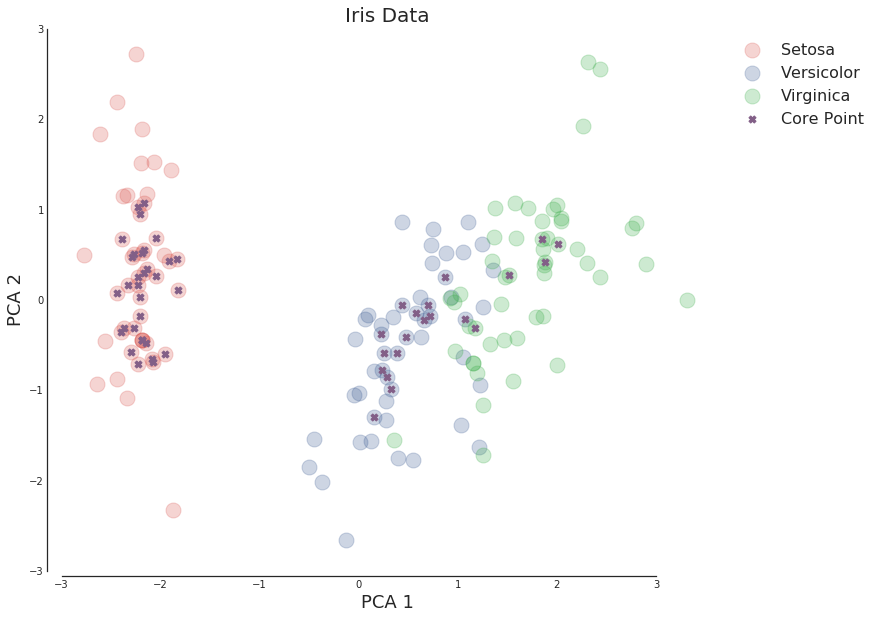

In [4]:
# Transform core points to PCA space
cp = pca.transform(mdl.components_)

# Colors used for plotting species
clr = [sns.xkcd_rgb["pale red"], 
       sns.xkcd_rgb["denim blue"], 
       sns.xkcd_rgb["medium green"]]

# Label data
lbls = ['Setosa', 'Versicolor', 'Virginica']
cols = ['PCA1', 'PCA2', 'Species']

# Define data
dt = pd.DataFrame(data, columns = cols)

# Make plot
fig, ax = plt.subplots(figsize=(12, 10))

# Plot three known clusters
for idx in range(3):
    tmp_df = dt[dt['Species'] == idx]
    ax.scatter(tmp_df['PCA1'], tmp_df['PCA2'], 
               color=clr[idx], label=lbls[idx], alpha=0.25, s=225)

# Plot core points
ax.scatter(cp[:, 0], cp[:, 1], label='Core Point',
           color=sns.xkcd_rgb['dusty purple'], 
           marker='X', alpha=1, s=50)

ax.set_xlabel('PCA 1')
ax.set_ylabel('PCA 2')
ax.set_title('Iris Data')
ax.legend(bbox_to_anchor=(1, 1), loc=2)

sns.despine(offset=5, trim=True)

-----

With the clusters identified, we can now explore the assignment of instances to each cluster. In the first Code cells below, we extract the cluster labels from the DBSCAN model. By using a Python `Counter` collection, we can quickly accumulate the number of instances in each cluster that are classified as noise. The results indicate the first two clusters (roughly overlapping the Iris Setosa and the Iris Versicolor data) are each roughly the same size. However, the Iris Virginica is much smaller, with the bulk of the remaining points classified as noise.

In the second Code cell below, we visually explore the same concept. In this plot, we show the Iris instances as large, semitransparent circles, along with the cluster labels as smaller, darker points. This plot demonstrates that outlying members of each species are misclassified as noise, but that instances of Iris Virginica are also strongly misclassified as Iris Versicolor. Given the overlap between these two clusters, this is not surprising. The higher density core of the Iris Versicolor leads the unsupervised cluster finding to misidentify Iris Virginica.

-----

In [5]:
from collections import Counter 
cnt =  Counter(np.sort(mdl.labels_))

# Display some basic results of the clustering
print('DBSCAN Cluster membership.')
print(30*'-')
for itm in cnt:
    if itm < 0:
        print(f'Noise Cluster : {cnt[itm]:>4d} members')
    else:
        print(f'Cluster {itm}     : {cnt[itm]:>4d} members')

DBSCAN Cluster membership.
------------------------------
Noise Cluster :   43 members
Cluster 0     :   45 members
Cluster 1     :   45 members
Cluster 2     :   17 members


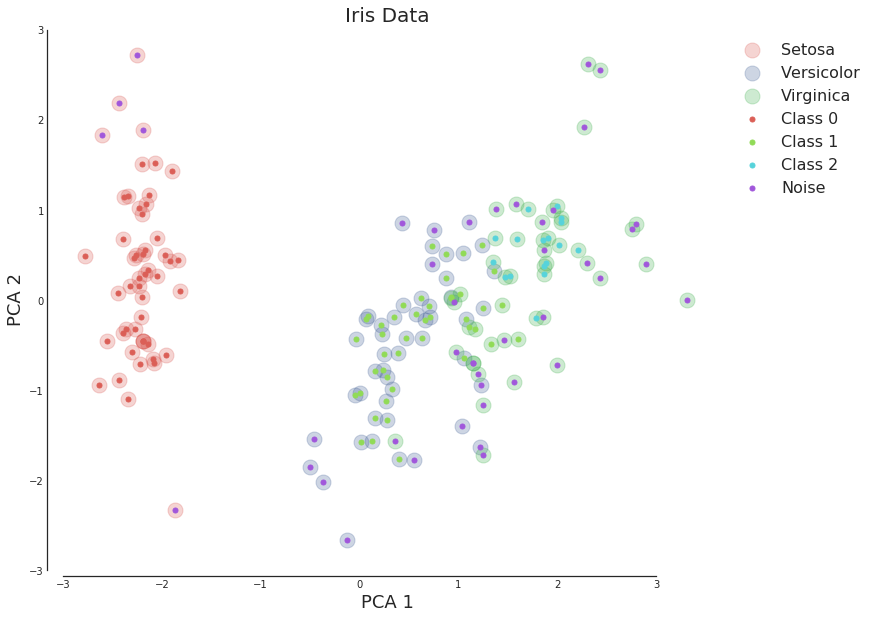

In [6]:
# Get cluster labels and assign plotting colors/labels.
dblbls = set(db.labels_)
dbclrs = sns.hls_palette(len(dblbls))
dbcls = ['Class {0}'.format(idx) if idx >= 0 else 'Noise' for idx in dblbls]

# Data
pc = pd.DataFrame(np.concatenate((xx, db.labels_.reshape((150, 1))), axis=1), 
                  columns = cols)

# Make plot
fig, ax = plt.subplots(figsize=(12, 10))

# Plot three known clusters
for idx in range(3):
    tmp_df = dt[dt['Species'] == idx]
    ax.scatter(tmp_df['PCA1'], tmp_df['PCA2'], color=clr[idx], 
               label=lbls[idx], alpha=0.25, s=225)

# Plot DBSCAN clusters (and noise)
for idx in list(dblbls):
    tmp_pdf = pc[pc['Species'] == idx]
    ax.scatter(tmp_pdf['PCA1'], tmp_pdf['PCA2'], 
               color=dbclrs[idx], label=dbcls[idx], alpha=1, s=25)

ax.set_xlabel('PCA 1')
ax.set_ylabel('PCA 2')
ax.set_title('Iris Data')
ax.legend(bbox_to_anchor=(1, 1), loc=2)

sns.despine(offset=5, trim=True)

-----

<font color='red' size = '5'> Student Exercise </font>

In the preceding cells, we used the DBSCAN algorithm to cluster the Iris data. Now that you have run the Notebook, go back and make the following changes to see how the results change. 

2. Change the `eps` parameter in the DBSCAN algorithm and visualize the new clusters.
3. Change the `min_samples` parameter in the DBSCAN algorithm and visualize the new clusters.
4. Try a different clustering algorithm on these data from the scikit learn library, such as [Mean Shift][skms] or [Agglomerative Clustering][skac].

Finally, can you explain (feel free to use the class forums) why the different algorithms performed differently when the parameters changed?

-----

[skms]: http://scikit-learn.org/stable/modules/clustering.html#mean-shift
[skac]: http://scikit-learn.org/stable/modules/clustering.html#hierarchical-clustering

[[Back to TOC]](#Table-of-Contents)


## DBSCAN: Digit Data

The Iris data are fairly clean and easy to cluster, especially since there are three species. We now switch to the handwritten digit data set in order to explore the application of the DBSCAN algorithm on a larger data set. Each instance in this data set has sixty-four features, and fall into one of ten classes. In the rest of this notebook, we will see how the different hyperparameters of the DBSCAN algorithm affect the clustering of these data.

In the following two Code cells, we first load the data into this notebook. Next, we apply a min-max scaler to ensure that all features are equally distributed (in this case to the range [0, 1]). Finally, we display a single image of each class to provide a visual reference for the results of the DBSCAN clustering.

-----

In [7]:
from sklearn.preprocessing import MinMaxScaler

# Load the digits data
digits = ds.load_digits()
    
# Now lets get the data and labels
x = MinMaxScaler().fit_transform(digits.data)
y = digits.target
images = digits.images

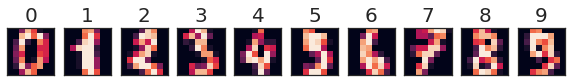

In [8]:
from helper_code import mlplots as mp

mp.plot_images(images[:10], np.arange(10))

-----

[[Back to TOC]](#Table-of-Contents)


### DBSCAN: Hyperparameter Tuning

One challenge when performing DBSCAN is the best choice for the hyperparameters that control the number and size of each cluster: `eps` and `min_samples`. In many cases, there may be little reason to expect an a priori number of clusters. In this case, a performance measure for the clustering can be used to select the values for these hyperparameters. On the other hand, if there is an expected number of clusters, one can select these values to return the expected number of clusters (plus one for the noise points).

In the following Code cell, we set the minimum number of samples to twenty, and perform a hyperparameter sweep for `eps` to find a value that generates ten clusters (plus the noise points). We select the range for `eps` to span `[1.05, 2.04]`, which will include the region of interest based on the scaling of the data (via the min-max scaling). If the number of clusters returned is eleven, we know we found the right number and display cluster membership for the noise group and several clusters (you can modify the Code cell to display the results for other clusters).

-----

In [9]:
for e in np.arange(1.05, 2.05, 0.1):
    lbls = DBSCAN(eps=e, metric='euclidean', min_samples=20).fit(x).labels_
    if np.unique(lbls).shape[0] == 11:
        print(f'If epsilon = {e:5.3f}')
        print(f'Noise Cluster contains {(lbls == -1).sum()} members')
        print(f'Cluster 0 contains {(lbls == 0).sum()} members')
        print(f'Cluster 9 contains {(lbls == 9).sum()} members')

If epsilon = 1.550
Noise Cluster contains 359 members
Cluster 0 contains 177 members
Cluster 9 contains 20 members


-----

[[Back to TOC]](#Table-of-Contents)

### DBSCAN: Clustering Digits

Now that we have determined the best hyperparameters (given the minimum number of samples), we can perform the clustering and explore the cluster membership. In the following Code cell, we define a function, `count_clusters`, that counts the number of members assigned to each cluster by the clustering algorithm (which in this case will be the DBSCAN) algorithm. The next Code cell performs DBSCAN clustering on these data using the hyperparameters computed earlier (we must redo the clustering since the results from each hyperparameter run were not saved).

The third Code cell uses a helper function that finds and displays an image for any instances that have been assigned to each cluster (we do not show any that were assigned to the noise point group, but that could be done). In this case, we see that the images are fairly distinct, with the exception of DBSCAN clusters one, four, and nine (and original digits one, eight, and nine). This may simply be that the images selected for these digits were less clear, one approach to test this would be to make an average image for all members of assigned clusters.

The fourth Code cell shows the confusion matrix for the DBSCAN clusters. Note that we can create this matrix since we know the actual cluster labels. In this case, we also have to add an extra row for the noise points. From this, we see that the noise points are fairly well spread across all digits, with the exception of the digits zero and six, which are both classified with high accuracy. In addition, we see that actual digits one, eight, and nine are not clearly predicted, which matches the results from the visual display of the cluster members.

----

In [10]:
# Function to display cluster membership
def count_clusters(model):
    cnt =  Counter(np.sort(model.labels_))
    
    # Display some basic results of the clustering
    print('DBSCAN Cluster membership.')
    print(30*'-')
    
    for itm in cnt:
        if itm < 0:
            print(f'Noise Cluster : {cnt[itm]:>4d} members')
        else:
            print(f'Cluster {itm}     : {cnt[itm]:>4d} members')

In [11]:
# Perform DBSCAN clustering
dbsc = DBSCAN(eps=1.55, min_samples=20, metric='euclidean')
dbsc.fit(x)

# Display results
count_clusters(dbsc)

DBSCAN Cluster membership.
------------------------------
Noise Cluster :  359 members
Cluster 0     :  177 members
Cluster 1     :  185 members
Cluster 2     :  285 members
Cluster 3     :  176 members
Cluster 4     :   43 members
Cluster 5     :  137 members
Cluster 6     :  147 members
Cluster 7     :  143 members
Cluster 8     :  125 members
Cluster 9     :   20 members


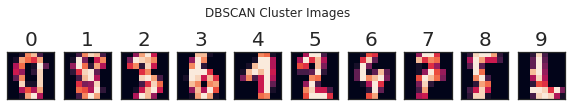

In [12]:
# Show cluster images
from helper_code import mlplots as mp            
mp.plot_db_images(dbsc, images)

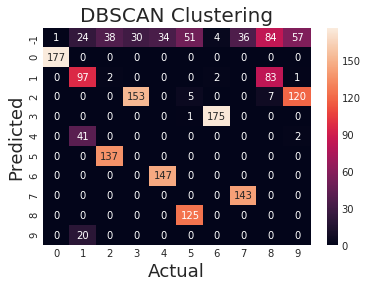

In [13]:
# Make confusion matrix for cluster
y_pred = dbsc.fit_predict(x)

# Display known clusters versus k-means clusters
mp.db_confusion(y, y_pred, np.arange(0, 10), np.arange(-1, 10),
                (10, 11), 'DBSCAN Clustering')

-----
[[Back to TOC]](#Table-of-Contents)


### DBSCAN: Dimensional Reduction

As the dimensionality of the data increases, the challenge of finding neighbors becomes more computationally intensive. Since this lies at the heart of the DBSCAN algorithm, we can perform dimension reduction prior to performing DBSCAN. This can, however, have unexpected effects. This is demonstrated in the following Code cells, where we first perform principal component analysis on the digit data, transforming the data to a twenty-five dimensional space (which retains over 90% of the variance in the original data). 

Next, we run DBSCAN over these reduced data using the same hyperparameters. This results in only three real clusters, with most of the data now being classified as luster zero. Looking at the images corresponding to these clusters, we see that cluster zero is rather ambiguous. Since the original hyperparameters were determined for the full dimensional space, we decrease the `eps` hyperparameters, which generates ten clusters (plus the noise points), and we display the number of digits assigned to each cluster, and visually display images for each cluster. While the visual display looks reasonable, the number assigned to each cluster is much lower than the true number, indicating the we may need to perform a more detailed hyperparameter sweep to produce a more robust recovery of the known digits in each class.

-----

In [14]:
# Principal Component Analysis
from sklearn.decomposition import PCA

# Compute PCA for digit data and transform
pca = PCA(n_components=25, copy=True)
data = pca.fit_transform(x)

In [15]:
# Perform DBSCAN on PCA features
pc_dbs = DBSCAN(eps=1.55, min_samples=20, metric='euclidean')
pc_dbs.fit(data)

# Display results
count_clusters(pc_dbs)

DBSCAN Cluster membership.
------------------------------
Noise Cluster :  102 members
Cluster 0     : 1499 members
Cluster 1     :  170 members
Cluster 2     :   26 members


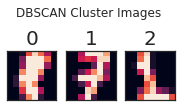

In [16]:
# Display representative images for each cluster
mp.plot_db_images(pc_dbs, images)

In [17]:
# Change eps hyperparameter and rerun DBSCAN
pc_dbs = DBSCAN(eps=1.25, min_samples=20, metric='euclidean')
pc_dbs.fit(data)

# Display results
count_clusters(pc_dbs)

DBSCAN Cluster membership.
------------------------------
Noise Cluster :  767 members
Cluster 0     :  171 members
Cluster 1     :  170 members
Cluster 2     :  117 members
Cluster 3     :  122 members
Cluster 4     :   86 members
Cluster 5     :   36 members
Cluster 6     :  103 members
Cluster 7     :   95 members
Cluster 8     :   90 members
Cluster 9     :   40 members


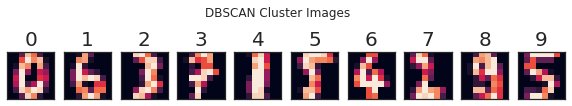

In [18]:
# Display representative images
mp.plot_db_images(pc_dbs, images)

-----

<font color='red' size = '5'> Student Exercise </font>


In the preceding cell, we used the DBSCAN algorithm to cluster the digit data set. Now that you have run the Notebook, go back and run it again, how do the results change? 

Now, make the following changes to see how the cluster assignments change.

1. Change the `eps` parameter, and see how many clusters are created and how many images are assigned to each cluster.

2. Change the `min_samples` parameter, and see how many clusters are created and how many images are assigned to each cluster.

3. Change the number of PCA components that are retained for clustering; how does this affect the results?

Finally, consider how the number of images assigned to the _noise_ cluster (or are outliers) varies. Can you explain how the parameters impact this quantity (feel free to use the class forums)?

-----

## Ancillary Information

The following links are to additional documentation that you might find helpful in learning this material. Reading these web-accessible documents is completely optional.

4. The scikit learn discussion on [density based clustering][1]
1. A Python implementation of a related [HDBSCAN algorithm][2]
2. Blog article on [density based clustering][3]


-----

[1]: http://scikit-learn.org/stable/modules/clustering.html#dbscan
[2]: http://hdbscan.readthedocs.io/en/latest/
[3]: https://blog.dominodatalab.com/topology-and-density-based-clustering/

**&copy; 2017: Robert J. Brunner at the University of Illinois.**

This notebook is released under the [Creative Commons license CC BY-NC-SA 4.0][ll]. Any reproduction, adaptation, distribution, dissemination or making available of this notebook for commercial use is not allowed unless authorized in writing by the copyright holder.

[ll]: https://creativecommons.org/licenses/by-nc-sa/4.0/legalcode 